<a href="https://colab.research.google.com/github/yg20029/AI-X_DeepLearning/blob/main/ResNet_34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os  # 운영체제와 관련된 일을 할 수 있게 도와주는 도구
import pandas as pd  # 데이터를 다룰 때 사용되는 아주 유명한 도구
from PIL import Image  # 이미지를 열고, 다루고, 저장할 수 있는 도구
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset  # 데이터를 쉽게 나누고 관리하게 도와주는 도구들
from torchvision import datasets, transforms, models  # 이미지 관련 작업에 사용되는 유용한 도구들
from google.colab import drive  # 구글 드라이브와 연결하기 위해 사용하는 도구
import matplotlib.pyplot as plt  # 데이터를 보기 좋게 그래프로 보여주는 도구
import torch.nn as nn  # 신경망을 만들 때 사용하는 도구
import torch  # 인공지능을 만들기 위한 기본 도구
import torch.nn.functional as F  # 신경망에서 자주 사용하는 함수들
import gc  # 메모리를 정리하는 도구
import torchvision  # 컴퓨터 비전(이미지 처리) 관련 작업에 도움을 주는 도구

In [2]:
!pip install kaggle  # Kaggle 데이터를 사용하기 위해 필요한 프로그램 설치

In [3]:
import kagglehub  # Kaggle 데이터를 다운로드하는 데 도움을 주는 도구

# Kaggle에서 최신 데이터셋 다운로드
path = kagglehub.dataset_download("gpiosenka/sports-classification")

print("Path to dataset files:", path)  # 데이터가 저장된 경로 출력

100%|██████████| 424M/424M [00:04<00:00, 111MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9


In [5]:
# 학습용(train)과 검증용(validation) 데이터 경로 설정
train_dir = "/root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9/train"
val_dir = "/root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9/valid"

In [6]:
# 사용 가능한 장치 확인 (GPU가 있으면 사용, 없으면 CPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # 어떤 장치를 사용하는지 출력

# 데이터 전처리 작업
# 이미지를 학습하기 전에 적절한 크기와 형식으로 변환하는 과정
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # 이미지를 224x224 크기로 자르기
        transforms.RandomHorizontalFlip(),  # 이미지를 좌우로 뒤집기
        transforms.ToTensor(),  # 이미지를 텐서(숫자 배열)로 변환
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 이미지의 색을 정규화
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),  # 이미지를 224x224 크기로 조정
        transforms.ToTensor(),  # 이미지를 텐서로 변환
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 이미지의 색을 정규화
    ]),
}

# 학습용 데이터셋과 검증용 데이터셋 불러오기
train_dataset = datasets.ImageFolder(train_dir, data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, data_transforms['val'])

Using device: cuda


In [7]:
# 데이터셋 정보 출력
print(f"Number of classes: {len(train_dataset.classes)}")  # 클래스(종류) 개수
print(f"Classes: {train_dataset.classes}")  # 클래스 이름
print(f"Number of training images: {len(train_dataset)}")  # 학습용 이미지 개수

# 첫 번째 이미지의 크기 확인
print(f"image shape: {train_dataset[0][0].shape}")

Number of classes: 100
Classes: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'r

(-0.5, 223.5, 223.5, -0.5)

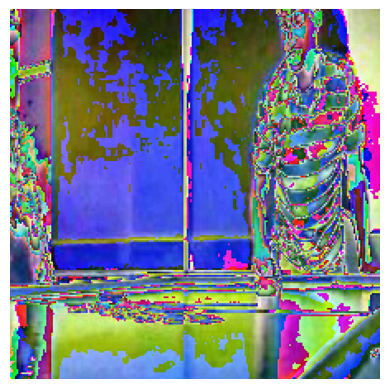

In [8]:

# 학습용 데이터셋에서 첫 번째 이미지를 시각화
img_tensor = train_dataset[0][0]  # 첫 번째 이미지 텐서 가져오기

# 텐서를 PIL 이미지로 변환
to_pil = transforms.ToPILImage()
img_pil = to_pil(img_tensor)

# 이미지를 화면에 표시
plt.imshow(img_pil)  # 이미지를 보여줌
plt.axis('off')  # 축 숨기기

In [9]:
import wandb  # 모델 학습 기록과 하이퍼파라미터 튜닝에 도움을 주는 도구
import random  # 랜덤한 값을 생성하는 데 사용하는 도구
from torchvision import models

In [10]:
!pip install wandb  # Weights & Biases 라이브러리 설치

In [11]:
!wandb login  # Weights & Biases 계정 로그인

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [17]:

# train_model 함수 수정
def train_model(config=None):
    with wandb.init(config=config):  # 새로운 실행 초기화
        config = wandb.config

        # 데이터 로더 업데이트
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

        # ResNet34 모델 초기화
        model = models.resnet34(weights='IMAGENET1K_V1')
        model.fc = nn.Linear(model.fc.in_features, 100)
        model = model.to(device)

        # 손실 함수 정의
        criterion = nn.CrossEntropyLoss()

        # 옵티마이저 정의
        if config.optimizer == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
        elif config.optimizer == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay, momentum=0.9)

        # 학습 루프
        for epoch in range(config.epochs):
            model.train()
            train_loss = 0.0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                # 순방향 패스
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)

                # 역방향 패스 및 최적화
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # 검증 루프
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_accuracy = correct / total

            # 메트릭 기록
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss / len(train_loader),
                'val_loss': val_loss / len(val_loader),
                'val_accuracy': val_accuracy
            })
            print(f"epoch {epoch+1} done.")

        print(f"Run complete. Final validation accuracy: {val_accuracy:.2f}")
        return model  # 학습된 모델 반환

# 최적의 하이퍼파라미터로 학습 실행
optimal_config = {
    'batch_size': 32,
    'epochs': 10,
    'learning_rate': 0.001,
    'optimizer': 'sgd',
    'weight_decay': 0.001
}

model = train_model(optimal_config)



epoch 1 done.
epoch 2 done.
epoch 3 done.
epoch 4 done.
epoch 5 done.
epoch 6 done.
epoch 7 done.
epoch 8 done.
epoch 9 done.
epoch 10 done.
Run complete. Final validation accuracy: 0.94


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇██████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
train_loss,0.41175
val_accuracy,0.944
val_loss,0.17532


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


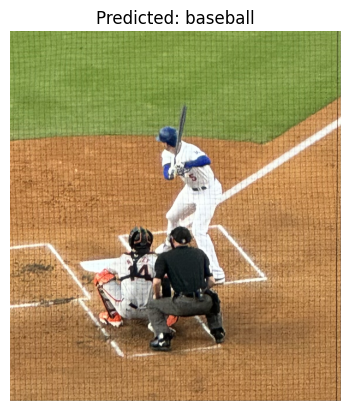

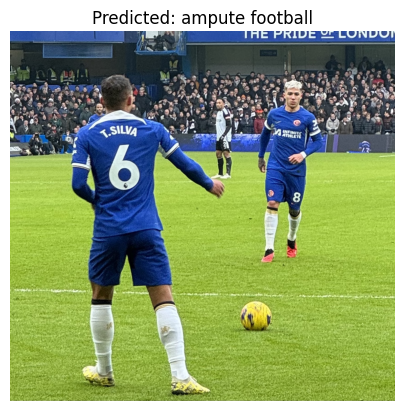

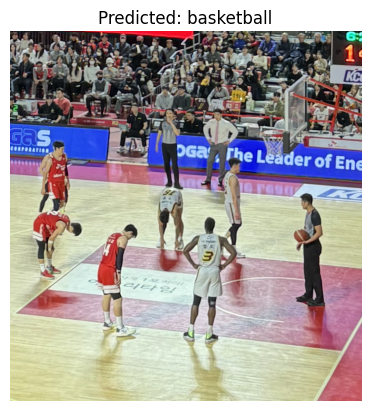

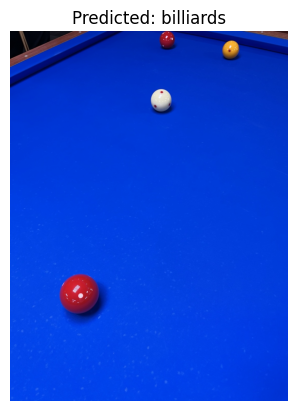

In [18]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 최적 하이퍼파라미터로 학습된 모델에 이미지 넣어보기
def test_model_with_images(model, image_paths):
    model.eval()
    transform = data_transforms['val']

    for image_path in image_paths:
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(img_tensor)
            _, predicted = torch.max(outputs, 1)
            class_name = train_dataset.classes[predicted.item()]

        plt.imshow(img)
        plt.title(f"Predicted: {class_name}")
        plt.axis('off')
        plt.show()

# 테스트에 사용할 이미지 경로 목록
sample_images = ['/content/drive/MyDrive/photo/aaa.jpg', '/content/drive/MyDrive/photo/aab.jpg', '/content/drive/MyDrive/photo/aac.jpg', '/content/drive/MyDrive/photo/aad.jpg',]  # 실제 경로로 변경

# 학습된 모델과 테스트 이미지로 결과 확인
test_model_with_images(model, sample_images)